# [RNN(Recurrent Neural Networks)](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)

## Vanilla RNN
- $h_t$: 은닉층
- $y_t$: 출력층
- $X_t$: 입력층
- $tanh()$: 비선형 활성화 함수

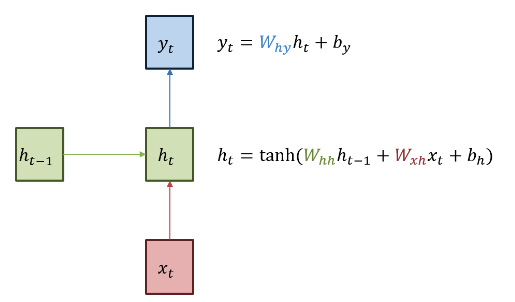

### [Vanilla RNN 단점](https://needjarvis.tistory.com/684)

- 일반적인 RNN의 경우 짧은 시퀀스를 처리할 경우 유리하며, 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀어지는 경우 학습 능력이 현저하게 저하된다.

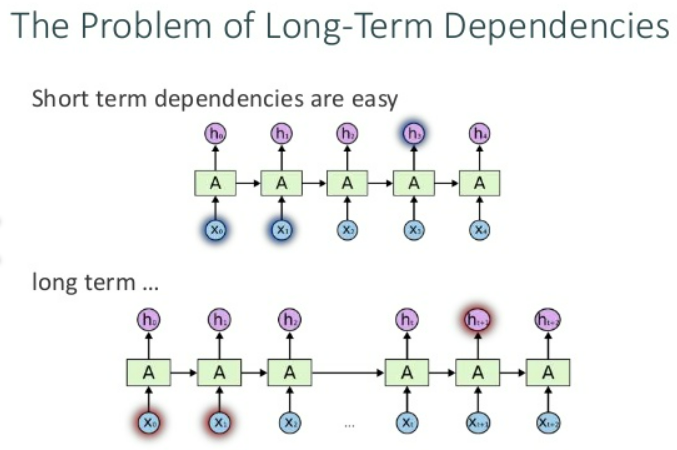

## [LSTM(Long Short Term Memory)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   
> Vanilla RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 `vanishing gradient problem`이라고 합니다.    
  
이 문제를 극복하기 위해서 고안된 것이 바로 LSTM입니다.

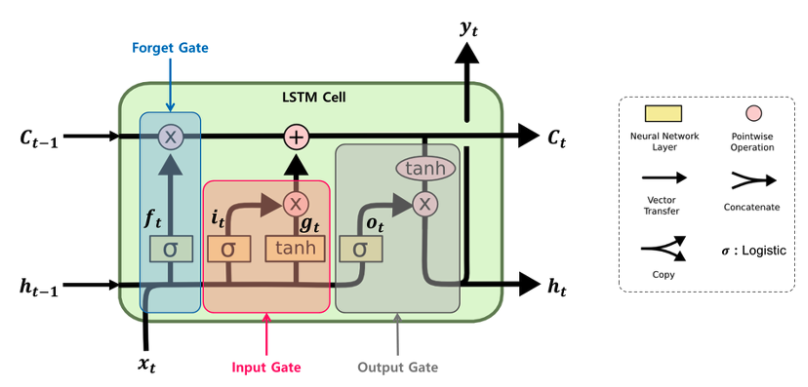

### LSTM 구조 설명
LSTM의 핵심은 cell state인데, 모듈 그림에서 수평으로 그어진 윗 선에 해당한다.  
Cell state는 컨베이어 벨트와 같아서, 작은 linear interaction만을 적용히키면서 전체 체인을 계속 구동시킨다.  
  
Cell state에 뭔가를 더하거나 없앨 수 있는데, 이 방법을 Gate라고 한다.

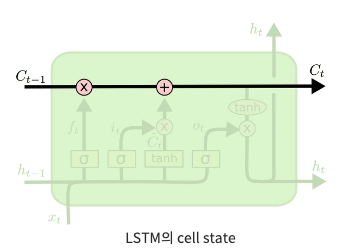

아래 그림은 sigmoid layer(0과 1 사이의 숫자를 내보냄)와 pointwise 곱셈을 나타낸 것이다.

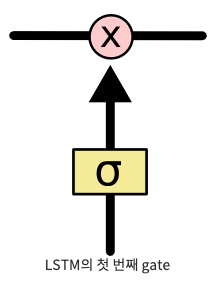

- Forget Gate   
과거 정보를 얼마나 잊을지에 대한 단계이다. 결과 값이 1이면 "이전 상태의 모든 정보를 보존"가 되고, 0이면 "이전 상태의 모든 정보를 삭제"가 된다.

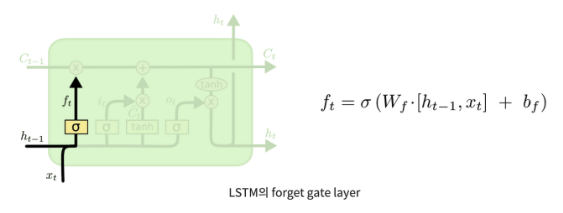

- Input Gate  
현재 정보를 얼마나 기억할 것인지에 대한 단계이다.

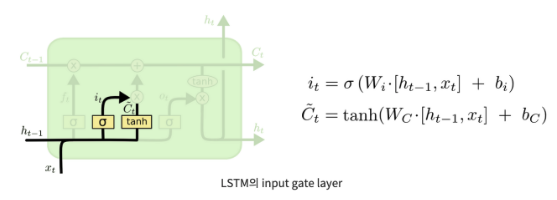

- State Update  
이전 cell state인 C(t-1)를 업데이트해서 새로운 cell state인 C(t)를 만드는 단계이다.

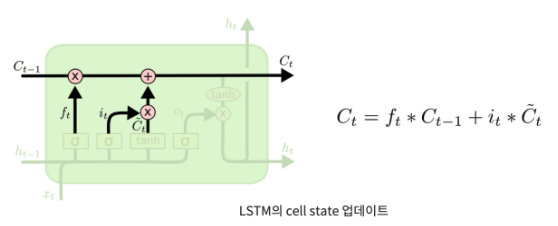

- Output Gate   
다음 state로 내보낼 output(hidden state)을 구하는 단계이다.

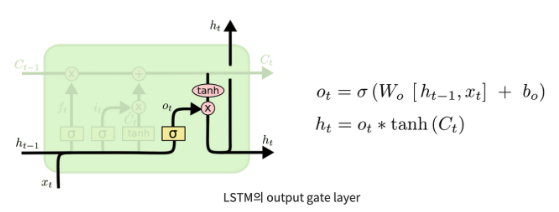

## Bi-LSTM(Bi-directional long short term memory)
- RNN이나 LSTM은 입력 순서를 시간 순대로 입력하기 때문에 결과물이 직전 패턴을 기반으로 수렴하는 경향을 보인다는 한계가 있습니다.
- 이 단점을 해결하는 목적으로 양방향 순환신경망(Bi-LSTM)이 제안되었습니다.

예를 들어 "나는 영화를 보았습니다."에서     
- RNN/LSTM인 경우, "나는"을 이용해서 "영화를" 예측해야 합니다.    
(즉, 예측이 힘듭니다.)  
- Bi-LSTM인 경우, "나는", "보았습니다."를 이용해서 "영화를" 예측하는 구조입니다.

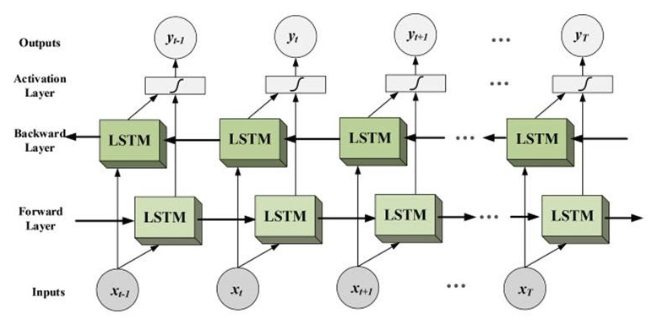

# [LSTM V1](https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/3-2.TextLSTM/TextLSTM.ipynb)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
n_step = 3 # number of cells(= number of Step)
n_hidden = 128 # number of hidden units in one cell

## Data

### 데이터 생성

In [ ]:
seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star']
seq_data

['make',
 'need',
 'coal',
 'word',
 'love',
 'hate',
 'live',
 'home',
 'hash',
 'star']

### 토큰화

In [ ]:
char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']
len(char_arr)

26

### 사전생성

In [ ]:
char_dict = {n: i for i, n in enumerate(char_arr)}
number_dict = {i: w for i, w in enumerate(char_arr)}
n_class = len(char_dict)  # number of class(=number of vocab)
n_class

26

## Dataset

### 디버깅

In [ ]:
seq = seq_data[0]
seq

'make'

In [ ]:
seq[:-1] # features

'mak'

In [ ]:
input = [char_dict[n] for n in seq[:-1]]
input # (m, a, k) -> (12, 0, 10)

[12, 0, 10]

In [ ]:
[number_dict[n] for n in input]

['m', 'a', 'k']

In [ ]:
seq[-1] # target

'e'

In [ ]:
target = char_dict[seq[-1]]
target, number_dict[target]

(4, 'e')

In [ ]:
np.eye(n_class)[input] # 원핫인코딩 (embedding)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def make_batch():
    input_batch, target_batch = [], []

    for seq in seq_data:
        input = [char_dict[n] for n in seq[:-1]] # 'm', 'a' , 'k' is input
        target = char_dict[seq[-1]] # 'e' is target
        input_batch.append(np.eye(n_class)[input]) # 원핫인코딩(embedding)
        target_batch.append(target)

    return input_batch, target_batch

In [ ]:
input_batch, target_batch = make_batch()
# input_batch => (batch_size, input_size, embedding_size)
np.array(input_batch).shape, np.array(target_batch).shape

((10, 3, 26), (10,))

## LSTM 모델 생성

In [ ]:
class TextLSTM(nn.Module):
    def __init__(self, n_class, n_hidden=128):
        super().__init__()

        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden)
        self.linear = nn.Linear(n_hidden, n_class, bias=False)

    def forward(self, X): # X => (batch_size, input_size, embedding_size)
        input = X.transpose(0, 1)  # input : (input_size, batch_size, embedding_size)

        hidden_state = torch.zeros(1, len(X), n_hidden)  # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        cell_state = torch.zeros(1, len(X), n_hidden)     # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]

        # outputs: [input_size, batch_size, n_hidden]
        outputs, (hidden_state, cell_state) = self.lstm(input, (hidden_state, cell_state)) # cell_state는 사용하지 않음!!!
        _output = outputs[-1]  # _output: [batch_size, n_hidden] -> outputs 또는 hidden_state 아무거나 사용 가능!!
        pred = self.linear(_output) # pred : [batch_size, n_class]
        return pred

## 모델 학습

In [ ]:
model = TextLSTM(n_class)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_batch, target_batch = make_batch()
input_batch = torch.FloatTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

<ipython-input-16-989fcd98c72a>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_batch = torch.FloatTensor(input_batch)


In [ ]:
for epoch in range(1000):

    output = model(input_batch) # batch_size = 전체 데이터 크기
    loss = criterion(output, target_batch)
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0100 cost = 0.534812
Epoch: 0200 cost = 0.034199
Epoch: 0300 cost = 0.009320
Epoch: 0400 cost = 0.004269
Epoch: 0500 cost = 0.002486
Epoch: 0600 cost = 0.001643
Epoch: 0700 cost = 0.001172
Epoch: 0800 cost = 0.000881
Epoch: 0900 cost = 0.000688
Epoch: 1000 cost = 0.000552


## 모델 예측

In [ ]:
pred = model(input_batch)
pred.shape

torch.Size([10, 26])

In [ ]:
pred_soft = pred.softmax(dim=1)
pred_soft.shape

torch.Size([10, 26])

In [ ]:
pred_max = pred_soft.argmax(dim=1)
pred_max.shape

torch.Size([10])

In [ ]:
inputs = [sen[:3] for sen in seq_data]

print(inputs, '->', [number_dict[n.item()] for n in pred_max])

['mak', 'nee', 'coa', 'wor', 'lov', 'hat', 'liv', 'hom', 'has', 'sta'] -> ['e', 'd', 'l', 'd', 'e', 'e', 'e', 'e', 'h', 'r']


# LSTM V2 with time series

## 시계열 분석


### 시계열 데이터

- 일정기간 동안 수집된 순차적 데이터 셋의 집합.
- 시간의 흐름에 따라 순서대로 관측되어 시간의 영향을 받게 되는 데이터 ex) 일별, 월별, 분기별, 년도별 ..
  - 이렇게 순차적으로 발생한 연속적인 관측치는 서로 상관관계를 맺고 있음

### 시계열 데이터 분석의 목적

- 미래의 값을 예측하기 위함.
- 시계열이 갖고 있는 법칙성을 발견해 이를 모형화하고 추정된 모형을 통해 미래의 값을 예측하기 위해 분석.

### 시계열 데이터 예시

- 쇼핑몰 구매 데이터
- 소비자 물가 지수
- 일일 주식 트렌드
- 월별/ 분기별/ 연도별 특정 사건의 수치

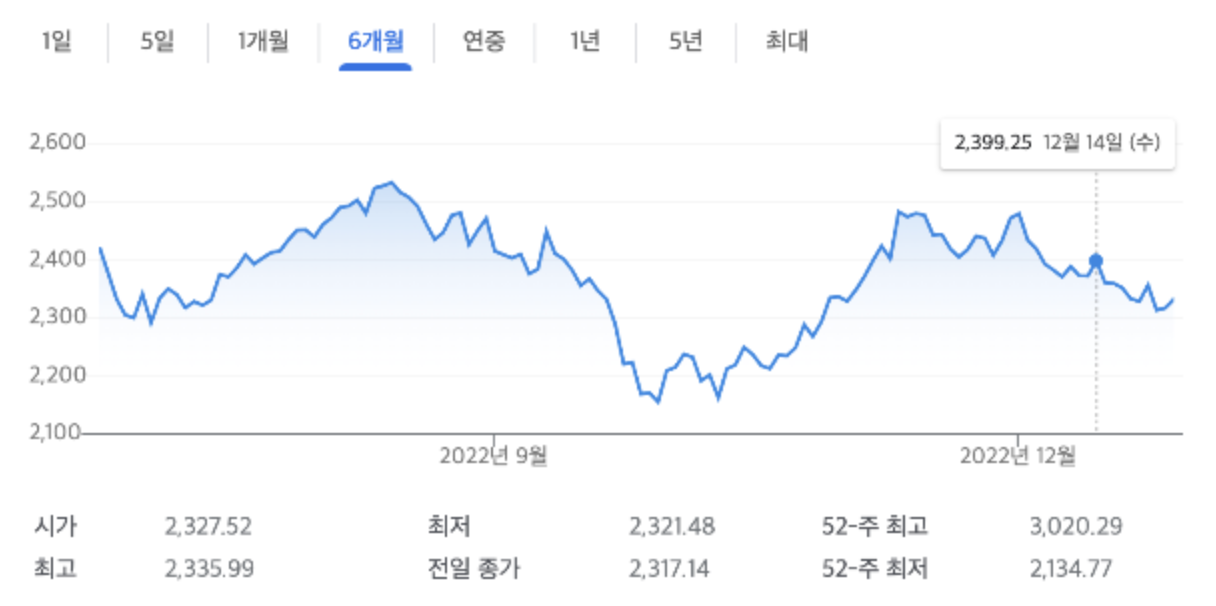

In [ ]:
from tqdm.auto import tqdm
import random
import os

import torch

import pandas as pd
import numpy as np
import pandas_datareader.data as web

In [ ]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Data

### Load Data

In [ ]:
df = web.DataReader('005930', 'naver', start='2022-01-01', end='2022-12-31')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03,79400,79800,78200,78600,13502112
2022-01-04,78800,79200,78300,78700,12427416
2022-01-05,78800,79000,76400,77400,25470640
2022-01-06,76700,77600,76600,76900,12931954
2022-01-07,78100,78400,77400,78300,15163757


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2022-01-03 to 2022-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    246 non-null    object
 1   High    246 non-null    object
 2   Low     246 non-null    object
 3   Close   246 non-null    object
 4   Volume  246 non-null    object
dtypes: object(5)
memory usage: 11.5+ KB


In [ ]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2022-01-03 to 2022-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    246 non-null    int64
 1   High    246 non-null    int64
 2   Low     246 non-null    int64
 3   Close   246 non-null    int64
 4   Volume  246 non-null    int64
dtypes: int64(5)
memory usage: 11.5 KB


### Scaling

In [ ]:
data = df.to_numpy()

data.shape

(246, 5)

In [ ]:
data

array([[   79400,    79800,    78200,    78600, 13502112],
       [   78800,    79200,    78300,    78700, 12427416],
       [   78800,    79000,    76400,    77400, 25470640],
       ...,
       [   58000,    58400,    57900,    58100, 10667027],
       [   57600,    57600,    56400,    56600, 14665410],
       [   56000,    56200,    55300,    55300, 11295935]])

- minmax scaling

In [ ]:
mins = data.min(axis=0)
sizes = data.max(axis=0) - mins

In [ ]:
scaled_data = (data - mins) / sizes
scaled_data

array([[0.99632353, 1.        , 0.98507463, 0.98859316, 0.24037609],
       [0.97426471, 0.97709924, 0.98880597, 0.99239544, 0.20697498],
       [0.97426471, 0.96946565, 0.91791045, 0.94296578, 0.61235305],
       ...,
       [0.20955882, 0.18320611, 0.22761194, 0.20912548, 0.1522628 ],
       [0.19485294, 0.15267176, 0.17164179, 0.15209125, 0.27653091],
       [0.13602941, 0.09923664, 0.13059701, 0.1026616 , 0.17180901]])

- 원복

In [ ]:
(scaled_data * sizes) + mins

array([[   79400.,    79800.,    78200.,    78600., 13502112.],
       [   78800.,    79200.,    78300.,    78700., 12427416.],
       [   78800.,    79000.,    76400.,    77400., 25470640.],
       ...,
       [   58000.,    58400.,    57900.,    58100., 10667027.],
       [   57600.,    57600.,    56400.,    56600., 14665410.],
       [   56000.,    56200.,    55300.,    55300., 11295935.]])

### [Series Dataset](https://velog.io/@lazy_learner/LSTM-%EC%8B%9C%EA%B3%84%EC%97%B4-%EC%98%88%EC%B8%A1-%EB%AA%A8%EB%93%88-%EB%A7%8C%EB%93%A4%EA%B8%B0-1)

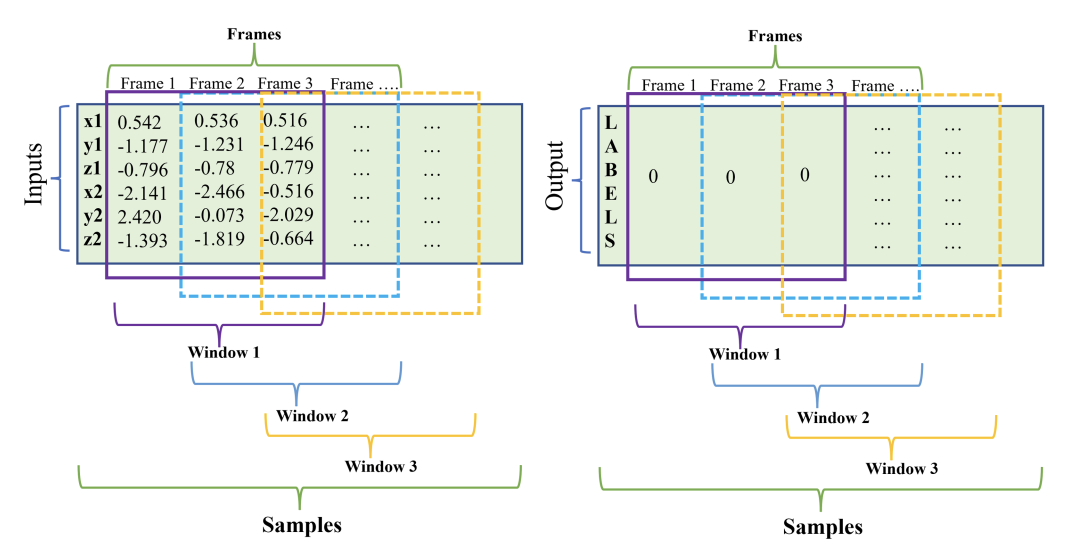

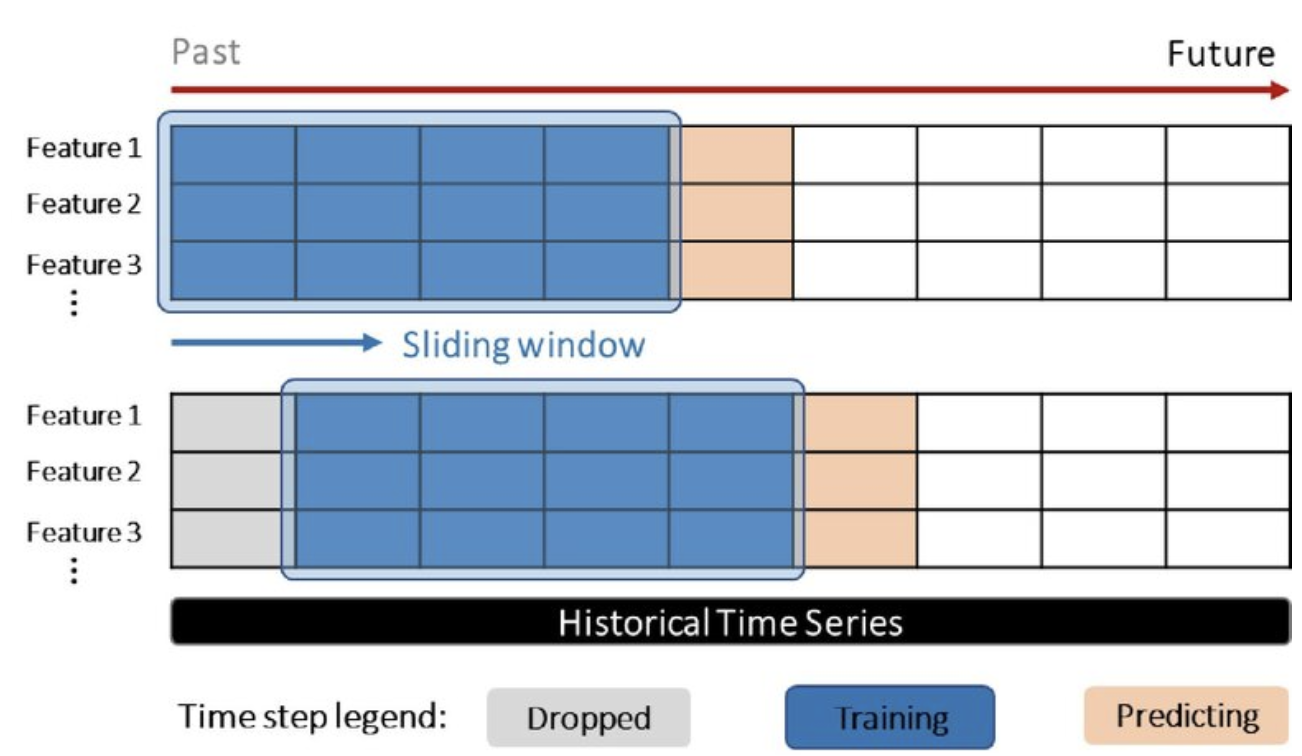

- input_len: 입력길이
- pred_len: 예측길이

In [ ]:
def transform_to_series_data(data,mins,sizes,input_len=10,pred_len=5):
    # 스케일링
    data = (data - mins) / sizes

    x_list = []
    y_list = []
    for i in range(input_len, data.shape[0] + 1 - pred_len):
        x = data[i-input_len:i] # 입력데이터 seq(10) , feature(5)
        x_list.append(x)
        y = data[i:i+pred_len, 3] # seq(5)
        y_list.append(y)
    x = np.array(x_list) # batch, seq(10), feature(5)
    y = np.array(y_list) # batch, seq(5)

    return x, y

In [ ]:
x_train, y_train = transform_to_series_data(data,mins,sizes)
x_train.shape, y_train.shape

((232, 10, 5), (232, 5))

In [ ]:
x_train[0].shape

(10, 5)

In [ ]:
y_train[0]

array([0.94676806, 0.92775665, 0.90114068, 0.90874525, 0.87452471])

In [ ]:
scaled_data[10:15][:,3] # y_train[0]와 같음

array([0.94676806, 0.92775665, 0.90114068, 0.90874525, 0.87452471])

## Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class FinanceDataset(Dataset):
    def __init__(self,x,y):
        self.x = x # batch, seq(10), feature(5)
        self.y = y # batch,seq(6)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        item["x"] = torch.Tensor(self.x[idx])
        item["y"] = torch.Tensor(self.y[idx])
        return item

In [ ]:
dt = FinanceDataset(x_train,y_train)

In [ ]:
dt[0]

{'x': tensor([[0.9963, 1.0000, 0.9851, 0.9886, 0.2404],
         [0.9743, 0.9771, 0.9888, 0.9924, 0.2070],
         [0.9743, 0.9695, 0.9179, 0.9430, 0.6124],
         [0.8971, 0.9160, 0.9254, 0.9240, 0.2227],
         [0.9485, 0.9466, 0.9552, 0.9772, 0.2920],
         [0.9485, 0.9351, 0.9440, 0.9658, 0.1299],
         [0.9596, 0.9695, 0.9776, 1.0000, 0.2316],
         [1.0000, 0.9924, 1.0000, 1.0000, 0.1626],
         [0.9926, 0.9809, 0.9739, 0.9620, 0.2524],
         [0.9338, 0.9351, 0.9440, 0.9392, 0.1345]]),
 'y': tensor([0.9468, 0.9278, 0.9011, 0.9087, 0.8745])}

In [ ]:
dt[0]['x'].shape, dt[0]['y'].shape

(torch.Size([10, 5]), torch.Size([5]))

## DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dl = DataLoader(dt, batch_size = 2)

In [ ]:
batch = next(iter(dl))
batch

{'x': tensor([[[0.9963, 1.0000, 0.9851, 0.9886, 0.2404],
          [0.9743, 0.9771, 0.9888, 0.9924, 0.2070],
          [0.9743, 0.9695, 0.9179, 0.9430, 0.6124],
          [0.8971, 0.9160, 0.9254, 0.9240, 0.2227],
          [0.9485, 0.9466, 0.9552, 0.9772, 0.2920],
          [0.9485, 0.9351, 0.9440, 0.9658, 0.1299],
          [0.9596, 0.9695, 0.9776, 1.0000, 0.2316],
          [1.0000, 0.9924, 1.0000, 1.0000, 0.1626],
          [0.9926, 0.9809, 0.9739, 0.9620, 0.2524],
          [0.9338, 0.9351, 0.9440, 0.9392, 0.1345]],
 
         [[0.9743, 0.9771, 0.9888, 0.9924, 0.2070],
          [0.9743, 0.9695, 0.9179, 0.9430, 0.6124],
          [0.8971, 0.9160, 0.9254, 0.9240, 0.2227],
          [0.9485, 0.9466, 0.9552, 0.9772, 0.2920],
          [0.9485, 0.9351, 0.9440, 0.9658, 0.1299],
          [0.9596, 0.9695, 0.9776, 1.0000, 0.2316],
          [1.0000, 0.9924, 1.0000, 1.0000, 0.1626],
          [0.9926, 0.9809, 0.9739, 0.9620, 0.2524],
          [0.9338, 0.9351, 0.9440, 0.9392, 0.1345],
    

## LSTM Model

In [ ]:
import torch.nn as nn

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, output_size=5, n_hidden=16, num_layers=1, bi_direction=False) -> None:
        super().__init__()
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        self.direction_num = 2 if bi_direction else 1

        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=self.n_hidden,
                            num_layers=self.num_layers, bidirectional=bi_direction)
        self.dense_layer = nn.Sequential(
            nn.Linear(self.n_hidden, self.n_hidden//2),
            nn.ReLU(),
            nn.Linear(self.n_hidden//2, output_size)
        )

    def forward(self, x):

        init_hidden = torch.zeros(
            self.num_layers*self.direction_num, x.shape[0], self.n_hidden
        )
        init_cell = torch.zeros(
            self.num_layers*self.direction_num, x.shape[0], self.n_hidden
        )

        out, (hidden_state, cell_state) = self.lstm_layer(x.transpose(1,0), (init_hidden, init_cell))

        predict = self.dense_layer(hidden_state[-1])
        return predict

In [ ]:
model = LSTMModel().to(device)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (lstm_layer): LSTM(5, 16, dropout=0.3)
  (dense_layer): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [ ]:
batch['x'].shape, batch['y'].shape

(torch.Size([2, 10, 5]), torch.Size([2, 5]))

In [ ]:
model(batch['x']).shape

torch.Size([2, 5])

## Engine

### EarlyStopper

In [ ]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else:
            return False

### train_loop

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

### test_loop

In [ ]:
@torch.inference_mode()
def test_loop(dataloader,model,loss_fn, device):
    epoch_loss = 0
    model.eval()

    pred_list = []
    for batch in dataloader:
        pred = model(batch["x"].to(device))

        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

        _pred = pred.to("cpu").numpy()
        pred_list.append(_pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list)
    return epoch_loss, pred

## Training

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

- Hyper Parameters

In [ ]:
input_size_enc = x_train.shape[2]
input_size_dec = 1
hidden_size = 32
is_attention = False

n_splits = 5
batch_size = 32
epochs = 1000
loss_fn = torch.nn.MSELoss()

- cross validation

In [ ]:
SEED = 42
cv = KFold(n_splits=n_splits,shuffle=True,random_state=SEED)

In [ ]:
reset_seeds(SEED)

best_loss_list = []
for i, (tri,vai) in enumerate(cv.split(x_train)):

    # 학습용
    train_dt = FinanceDataset(x_train[tri], y_train[tri])
    train_dl = DataLoader(train_dt,batch_size=batch_size,shuffle=False)

    # 검증용
    valid_dt = FinanceDataset(x_train[vai], y_train[vai])
    valid_dl = DataLoader(valid_dt,batch_size=batch_size,shuffle=False)

    model = LSTMModel().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    early_stopper = EarlyStopper(num_trials=30, save_path=f'best_model_{i}.pt')

    for epoch in tqdm(range(epochs)):
        train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)

        pred = pred * sizes[3] + mins[3] # 원래의 수치로 복원
        true = y_train[vai] * sizes[3] + mins[3] # 원래의 수치로 복원
        score = mean_absolute_percentage_error(true,pred)

        if not early_stopper.is_continuable(model, valid_loss):
            print(f'Cross Validation:{i} >> best loss: {early_stopper.best_loss}')
            best_loss_list.append(early_stopper.best_loss)
            break


  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:0 >> best loss: 0.0017480236710980535


  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:1 >> best loss: 0.0030258868355304003


  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:2 >> best loss: 0.0021667478140443563


  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:3 >> best loss: 0.0023352982243523


  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:4 >> best loss: 0.0025275531224906445


In [ ]:
np.mean(best_loss_list)

0.002360701933503151